# SSD PyTorch Demonstration

## Import module
First of all, import necessary modules and set hardware device.

In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
print("PyTorch version: " + str(torch.__version__))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.__str__() + ": " + torch.version.cuda + " available")

PyTorch version: 0.4.0
cuda: 9.0.176 available


## VOC dataset

### Declare the parameter set for data loading
One example is provided for the reader. Those parameters can be rewritten for initialization.

In [8]:
from voc2007_12 import VOCDataBase
from augmentation import *

dataset_parameter = {
    'root' : None, 'image_set' : "trainval", 'years' : None,
    'transforms' : None, 'keep_difficult' : False
}
dataset_parameter['transforms'] = Compose([RandomCrop(300, th=0.3), RandomHorizontalFlip(), NormalizeBoundingBox(), 
                                           Resize(300), SubstractData([104, 117, 123]), ToTensor()])
dataset_parameter['root'] = "/home/sanyu/Desktop/dl4cv/VOCdevkit"
dataset_parameter['years'] = ["2007", "2012"]

### Initialize data class
The function, collate, specifies how data packed for the dataloader with batch size. The reader can move it away. 

16551


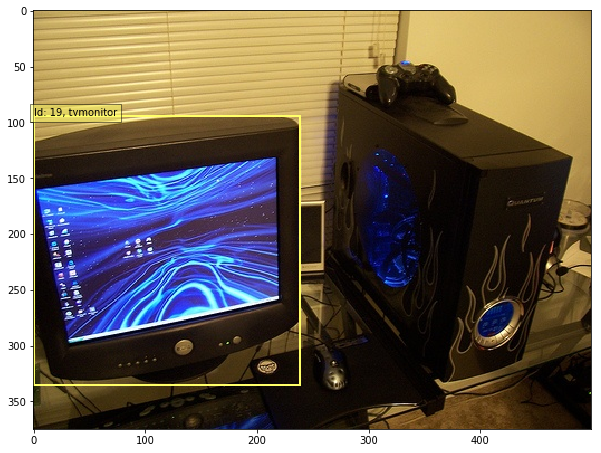

In [10]:
 def collate(batch):
    """Customized collate function for detection-oriented applications.The packed/return is expected 
       by the iterator of training, and the iterator of unpacked/argument here depends on VOCDataBase.__getitem__.
    Arguments:
      batch: (tuple) A tuple of tensor images and lists of annotations.
    Return:
        1) a stack of frames: (tensor), sized [#batch,3, 300, 300].     
        2) gt_boxes:  (list) annotations for a given image, length: #batch
        3) gt_labels: (list) annotations for a given image, length: #batch
    """
    gt_boxes = []
    frames = []
    gt_labels = []
    for image, boxes, labels in batch:
        gt_labels.append(labels)
        frames.append(image)
        gt_boxes.append(boxes)
    return torch.stack(frames, 0), (gt_boxes, gt_labels)

train_data = VOCDataBase(dataset_parameter)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, collate_fn = collate, num_workers=1)
train_data.showGroundTruth(92)

## Training

### Load VGG pretraining 
Load the vgg model from the refernce[1] of github page. Then, again the parameter set is for the training configuration.

In [ ]:
from ssd import SSD
model_local_path = './weights/vgg16_reducedfc.pth'
pre_train_vgg = torch.load(model_local_path)
model = SSD(pre_train_vgg)

train_parameter = {
    'n_epoch' : 9, 'learning_rate' : 1e-4, 'weight_decay' : 5e-4, 'momentum' : 0.9,
    'milestones' : None, 'gamma' : 0.1, 'device' : None
}
train_parameter['device'] = device

### Training 
Training on the device

In [ ]:
from train import Trainer

loss_total, loss_conf_out, loss_loc_out = [], [], []
train = Trainer(train_parameter, model)
train.train(loss_total, loss_conf_out, loss_loc_out, train_loader)

### Plot losses

In [ ]:
plt.plot(loss_total)
plt.plot(loss_conf_out)
plt.plot(loss_loc_out)

## Evaluation
### Initialize evaluation data/loader

In [ ]:
from voc2007_12 import VOCDataBase

dataset_parameter = {
    'root' : None, 'image_set' : "trainval", 'year' : None,
    'transforms' : None, 'keep_difficult' : False, 'mean' : [104., 117., 123.]
}
dataset_parameter['train_transforms'] = transforms.Compose([transforms.ToTensor()])
dataset_parameter['root'] = "./VOCdevkit"
dataset_parameter['year'] = "2007"
dataset_parameter['image_set'] = "test"

In [ ]:
eval_data = VOCDataBase(dataset_parameter)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=1, shuffle=False, collate_fn = detection_collate, num_workers=1)

### Eval

In [ ]:
from eval import Evaluation

eval_parameter = {'device' : None }
eval_parameter['device'] = device
eval_ = Evaluation(eval_parameter, model)
eval_.evaluate(model, eval_loader)